In [1]:
import os
import dgl
import matplotlib as plt
import networkx as nx
import numpy as np
import scanpy as sc 
import sklearn as sk
import squidpy as sq


ANNDATA_DIR = 'annData'
DLPFC_ANNDATA_DIR = os.path.join(ANNDATA_DIR, '1.DLPFC')

test_sample_id = '151507'

sample = sc.read_h5ad(os.path.join(DLPFC_ANNDATA_DIR, "{}.h5ad".format(test_sample_id)))

/home/edgar/miniconda3/envs/STGCNDBC/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [2]:
sample

AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'layer_guess'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'layer_guess_colors', 'spatial'
    obsm: 'spatial'

In [3]:
type(sample.obsm['spatial'])
coords = sample.obsm['spatial']

In [4]:
sample.obsm['spatial'].shape

(4226, 2)

In [5]:
n_nodes = sample.obsm['spatial'].shape[0]
n_nodes

4226

In [6]:
distances = sk.metrics.pairwise.euclidean_distances(coords, coords)

In [7]:
distances.shape

(4226, 4226)

In [56]:
min_distance = np.min(distances[distances!=0])
max_distance = np.max(distances)
total_distance = sum(distances)/2
distances /= total_distance
distances

array([[0.00000000e+00, 9.47958071e-04, 1.84400554e-04, ...,
        7.29465188e-04, 6.34167863e-04, 2.74147578e-04],
       [6.77156936e-04, 0.00000000e+00, 6.76488993e-04, ...,
        5.13020986e-04, 6.05588085e-04, 6.69841913e-04],
       [1.52176561e-04, 7.81530760e-04, 0.00000000e+00, ...,
        6.92803848e-04, 6.00108015e-04, 7.85209630e-05],
       ...,
       [5.83061210e-04, 5.74043107e-04, 6.71018240e-04, ...,
        0.00000000e+00, 2.10687882e-04, 6.99707205e-04],
       [4.37684927e-04, 5.85105903e-04, 5.01881565e-04, ...,
        1.81922887e-04, 0.00000000e+00, 5.20415265e-04],
       [2.05145425e-04, 7.01696866e-04, 7.11995903e-05, ...,
        6.55064688e-04, 5.64248076e-04, 0.00000000e+00]])

In [57]:
weights = 1 - distances - np.eye(n_nodes)
weights

array([[0.        , 0.99905204, 0.9998156 , ..., 0.99927053, 0.99936583,
        0.99972585],
       [0.99932284, 0.        , 0.99932351, ..., 0.99948698, 0.99939441,
        0.99933016],
       [0.99984782, 0.99921847, 0.        , ..., 0.9993072 , 0.99939989,
        0.99992148],
       ...,
       [0.99941694, 0.99942596, 0.99932898, ..., 0.        , 0.99978931,
        0.99930029],
       [0.99956232, 0.99941489, 0.99949812, ..., 0.99981808, 0.        ,
        0.99947958],
       [0.99979485, 0.9992983 , 0.9999288 , ..., 0.99934494, 0.99943575,
        0.        ]])

In [58]:
G = nx.from_numpy_array(weights, create_using=nx.Graph)
# nx.draw(G)
# plt.show()

In [11]:
# sample a subgraph
rng = np.random.default_rng()
subgraph_nodes = rng.choice(n_nodes, int(n_nodes * 0.01))
G_sub = G.subgraph(subgraph_nodes)

In [12]:
def weighted_layout(G, weight_attr='weight'):
    pos = nx.spring_layout(G)
    for u, v, data in G.edges(data=True):
        if weight_attr in data:
            w = data[weight_attr]
            pos[u] -= pos[v] * w * 0.1
            pos[v] += pos[u] * w * 0.1
    return pos

In [13]:
pos = weighted_layout(G_sub)

In [50]:
weights = [G_sub[u][v]['weight'] for u,v in G_sub.edges]
print(min(weights), max(weights))

0.11791612041553745 0.9778285989881412


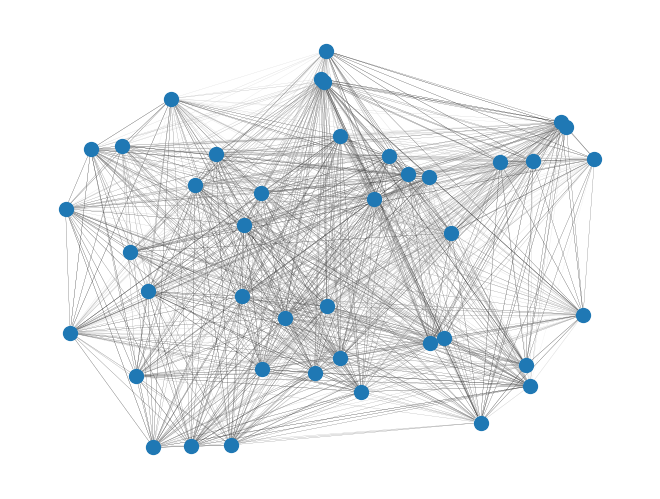

In [55]:
nx.draw(G_sub, pos, node_size=100, width=0.1, arrowstyle='-', edge_color=weights, edge_vmin=min(weights), edge_vmax=max(weights),  edge_cmap=plt.cm.gist_yarg)

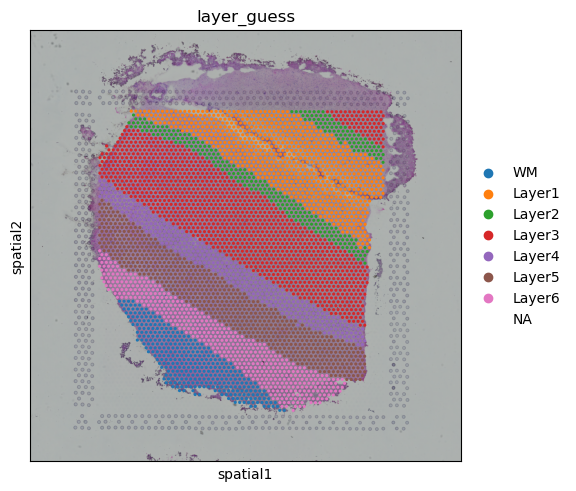

In [15]:
sq.pl.spatial_scatter(sample, color='layer_guess')